# Flight price prediction

In [1]:
#importing the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,classification_report
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

### Importing dataset
1. Data scrapped from the yatra.com and EsayMyTrip com 

In [2]:
#loading the data set
df= pd.read_csv('easy_mytrip_yatra.csv')
df.head()

,Date,Airline,Source,Destination,Dep_time,Arr_time,Durtion,Route,stop,price
0,25-Oct,GO FIRST,Bangalore,Delhi,6:00,8:40,02h 40m,BLR--->DEL,non-stop,"7,487"
1,25-Oct,GO FIRST,Bangalore,Delhi,21:15,23:55,02h 40m,BLR--->DEL,non-stop,"7,487"
2,25-Oct,SpiceJet,Bangalore,Delhi,2:10,4:50,02h 40m,BLR--->DEL,non-stop,"7,488"
3,25-Oct,Indigo,Bangalore,Delhi,12:55,15:40,02h 45m,BLR--->DEL,non-stop,"7,488"
4,25-Oct,Indigo,Bangalore,Delhi,14:35,17:20,02h 45m,BLR--->DEL,non-stop,"7,488"


In [3]:
df.shape

(7699, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7699 entries, 0 to 7698
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         7699 non-null   object
 1   Airline      7699 non-null   object
 2   Source       7699 non-null   object
 3   Destination  7699 non-null   object
 4   Dep_time     7699 non-null   object
 5   Arr_time     7699 non-null   object
 6   Durtion      7699 non-null   object
 7   Route        7699 non-null   object
 8   stop         7699 non-null   object
 9   price        7699 non-null   object
dtypes: object(10)
memory usage: 601.6+ KB


## Data cleaning 

In [5]:
#### Checking null values
df.isnull().sum()

Date           0
Airline        0
Source         0
Destination    0
Dep_time       0
Arr_time       0
Durtion        0
Route          0
stop           0
price          0
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
##Droping the Unamed columns 

df.dropna(subset=['price'],inplace = True)

In [8]:
df.isnull().sum()

Date           0
Airline        0
Source         0
Destination    0
Dep_time       0
Arr_time       0
Durtion        0
Route          0
stop           0
price          0
dtype: int64

In [9]:
#converting the objects to hours,minutes
df["Dep_hour"] = pd.to_datetime(df["Dep_time"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_time"]).dt.minute
df.drop(["Dep_time"], axis = 1, inplace = True)

In [10]:
#converting the objects to hours, minutes
df["Arr_hour"] = pd.to_datetime(df["Arr_time"]).dt.hour
df["Arr_min"] = pd.to_datetime(df["Arr_time"]).dt.minute
df.drop(["Arr_time"], axis = 1, inplace = True)

In [11]:
df.head()

,Date,Airline,Source,Destination,Durtion,Route,stop,price,Dep_hour,Dep_min,Arr_hour,Arr_min
0,25-Oct,GO FIRST,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,487",6,0,8,40
1,25-Oct,GO FIRST,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,487",21,15,23,55
2,25-Oct,SpiceJet,Bangalore,Delhi,02h 40m,BLR--->DEL,non-stop,"7,488",2,10,4,50
3,25-Oct,Indigo,Bangalore,Delhi,02h 45m,BLR--->DEL,non-stop,"7,488",12,55,15,40
4,25-Oct,Indigo,Bangalore,Delhi,02h 45m,BLR--->DEL,non-stop,"7,488",14,35,17,20


In [12]:
#replace the h,m from the duration 
df['Durtion']=df['Durtion'].str.replace("h",':')
df['Durtion']=df['Durtion'].str.replace("m",'')
df['Durtion']=df['Durtion'].str.replace(" ",'')

#spliting the hours and minutes 
df["Dur_hour"]=df['Durtion'].str.split(':').str[0]
df["Dur_min"]=df['Durtion'].str.split(':').str[1]
df.drop(["Durtion"], axis = 1, inplace = True)

In [13]:
#removing the comma symbole form price
df['price']=df['price'].str.replace(",","")

In [14]:
df['Day']=df['Date'].str.split("-").str[0]
df['Month']=df['Date'].str.split("-").str[1]


In [15]:
df.drop(["Date"], axis = 1, inplace = True)

In [16]:
column=['Airline', 'Source', 'Destination', 'Day', 'Month','Route','Dep_hour','Dep_min', 'Dur_hour','Dur_min','Arr_hour','Arr_min','stop','price']
  
# create the new index for columns
df=df.reindex(column, axis='columns')

In [17]:
df.head()

,Airline,Source,Destination,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,price
0,GO FIRST,Bangalore,Delhi,25,Oct,BLR--->DEL,6,0,02,40,8,40,non-stop,7487
1,GO FIRST,Bangalore,Delhi,25,Oct,BLR--->DEL,21,15,02,40,23,55,non-stop,7487
2,SpiceJet,Bangalore,Delhi,25,Oct,BLR--->DEL,2,10,02,40,4,50,non-stop,7488
3,Indigo,Bangalore,Delhi,25,Oct,BLR--->DEL,12,55,02,45,15,40,non-stop,7488
4,Indigo,Bangalore,Delhi,25,Oct,BLR--->DEL,14,35,02,45,17,20,non-stop,7488


In [18]:
df.to_csv("EasyMyTrip_yatra_Cleaned.csv")

In [19]:
#df=pd.read_csv("Cleaned_EasyMytrip.csv")
#df.head()

In [20]:
#df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [21]:
"""
df["Dep_hour"] = pd.to_datetime(df["Dep_hour"]).dt.hour
df["Dep_min"] = pd.to_datetime(df["Dep_min"]).dt.minute
df["Arr_hour"] = pd.to_datetime(df["Arr_hour"]).dt.hour
df["Arr_min"] = pd.to_datetime(df["Arr_min"]).dt.minute
df["Dur_hour"] = pd.to_datetime(df["Dur_hour"]).dt.hour
df["Dur_min"] = pd.to_datetime(df["Dur_min"]).dt.minute
"""

#converting to date fomate 

df["Day"] = pd.to_datetime(df.Day, format="%d").dt.day
df['Month'] =df['Month'].str.replace('Oct','10')
df['Month'] =df['Month'].str.replace('Nov','11')
df["Month"] = pd.to_datetime(df["Month"], format = "%m").dt.month

In [22]:
#converting object to numeric data type 
df["Dep_hour"]=pd.to_numeric(df["Dep_hour"])
df["Dur_min"]=pd.to_numeric(df["Dur_min"])
df['price']=pd.to_numeric(df['price'])

In [23]:
df.head()

,Airline,Source,Destination,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,price
0,GO FIRST,Bangalore,Delhi,25,10,BLR--->DEL,6,0,02,40,8,40,non-stop,7487
1,GO FIRST,Bangalore,Delhi,25,10,BLR--->DEL,21,15,02,40,23,55,non-stop,7487
2,SpiceJet,Bangalore,Delhi,25,10,BLR--->DEL,2,10,02,40,4,50,non-stop,7488
3,Indigo,Bangalore,Delhi,25,10,BLR--->DEL,12,55,02,45,15,40,non-stop,7488
4,Indigo,Bangalore,Delhi,25,10,BLR--->DEL,14,35,02,45,17,20,non-stop,7488


### Exploratory data Analysis

#### Univariant Analysis

Vistara      1986
Indigo       1234
Air India    1212
GO FIRST     1014
AirAsia       843
IndiGo        602
SpiceJet      519
Go First      236
Air Asia       53
Name: Airline, dtype: int64


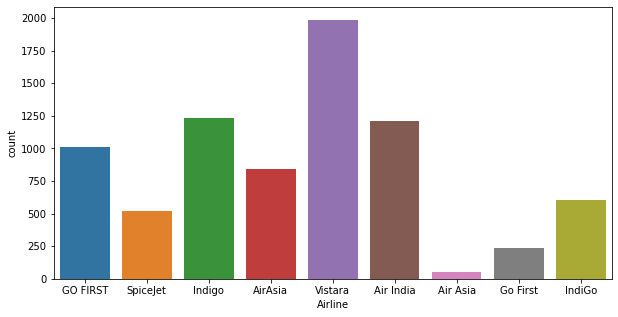

In [24]:
fig=plt.figure(figsize=(10,5))
sns.countplot(df['Airline'])
print(df['Airline'].value_counts())
plt.show()

Descrpition: indigo Have highest number of flights in demostic

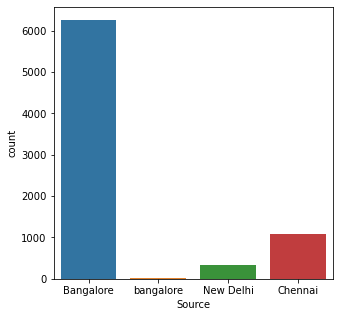

In [25]:
fig=plt.figure(figsize=(5,5))
sns.countplot(df['Source'])
plt.show()

Delhi     7369
Mumbai     330
Name: Destination, dtype: int64


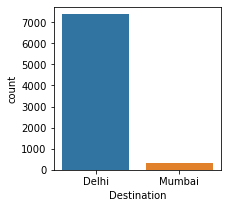

In [26]:
fig=plt.figure(figsize=(3,3))
sns.countplot(df['Destination'])
print(df['Destination'].value_counts())
plt.show()

23    383
22    313
21    304
20    303
17    302
16    293
18    292
25    292
19    287
28    284
1     284
27    271
24    269
2     268
31    261
26    260
29    257
30    245
15    211
9     206
8     205
14    196
5     196
13    195
11    194
12    194
10    193
7     189
6     188
3     184
4     180
Name: Day, dtype: int64


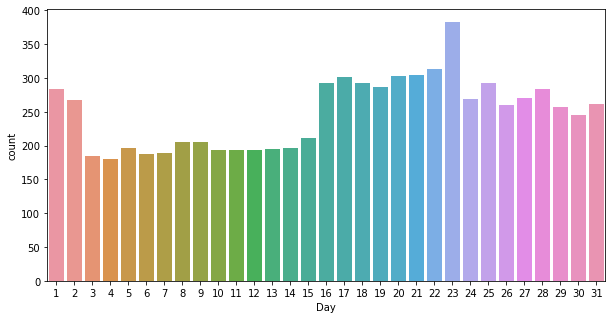

In [27]:
#number of flights from bangalore to delhi
fig=plt.figure(figsize=(10,5))
sns.countplot(df['Day'])
print(df['Day'].value_counts())
plt.show()

11    5128
10    2571
Name: Month, dtype: int64


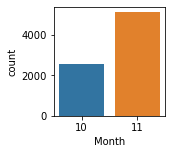

In [28]:
fig=plt.figure(figsize=(2,2))
sns.countplot(df['Month'])
print(df['Month'].value_counts())
plt.show()

In [29]:
#flight routes
print(df['Route'].unique())

['BLR--->DEL' 'BLR--->BOM-->DEL' 'BLR--->GOI-->DEL' 'BLR--->CCU-->DEL'
 'BLR--->COK-->DEL' 'BLR--->IXR-->DEL' 'BLR--->IXB-->DEL'
 'BLR--->GAU-->DEL' 'BLR--->HYD-->DEL' 'BLR--->LKO-->DEL'
 'BLR--->AMD-->DEL' 'BLR--->VNS-->DEL' 'BLR--->NAG-->DEL'
 'BLR--->BDQ-->DEL' 'BLR--->JAI-->DEL' 'BLR--->MAA-->DEL'
 'BLR--->UDR-->DEL' 'BLR--->STV-->DEL' 'BLR--->SAG-->DEL'
 'BLR--->JLR-->DEL' 'BLR--->BBI-->DEL' 'BLR--->PAT-->DEL'
 'BLR--->IXC-->DEL' 'BLR--->PNQ-->DEL' 'BLR--->VTZ-->DEL'
 'BLR--->BHO-->DEL' 'BLR--->TRV-->DEL' 'BLR-->DEL' 'DEL-->BOM' 'MAA-->DEL']


1-stop      6209
non-stop    1355
2-stop       123
3-stop        12
Name: stop, dtype: int64


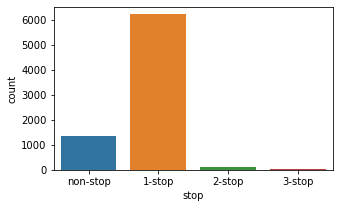

In [30]:
fig=plt.figure(figsize=(5,3))
sns.countplot(df['stop'])
print(df['stop'].value_counts())
plt.show()

### Multivrient analysis

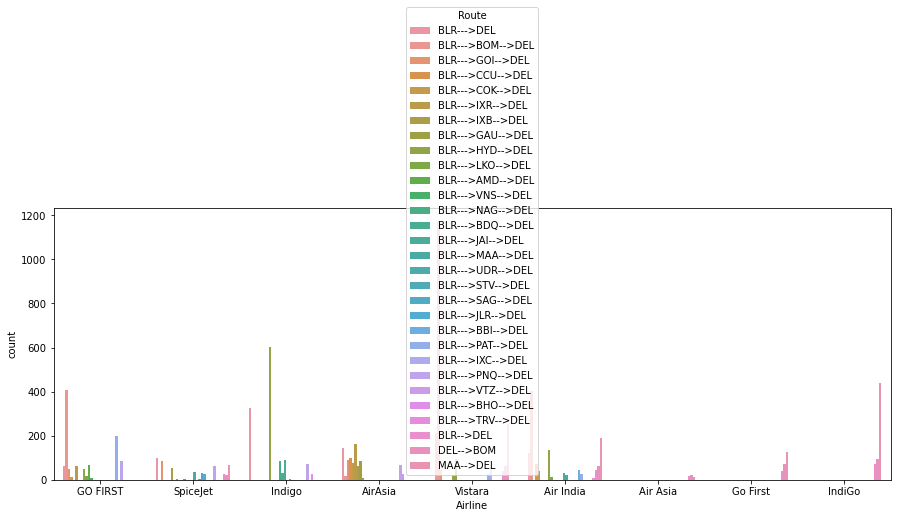

In [31]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x='Airline',hue='Route',  data=df)
plt.show()

In [32]:
# Minmum price of the flight of that day
df.groupby(df['Day'])['price'].min()

Day
1     7350
2     6050
3     7485
4     6186
5     7485
6     7485
7     7485
8     7404
9     6186
10    7485
11    7485
12    7485
13    7485
14    7485
15    7485
16    6186
17    2270
18    2270
19    3916
20    3916
21    3916
22    3916
23    3861
24    3916
25    3861
26    7352
27    7352
28    7352
29    7352
30    7352
31    7350
Name: price, dtype: int64

In [33]:
#Minimum Airline fare 
df.groupby(["Source", "Destination"])["price"].min()

Source     Destination
Bangalore  Delhi          3861
Chennai    Delhi          2270
New Delhi  Mumbai         5953
bangalore  Delhi          5953
Name: price, dtype: int64

In [34]:
#Cheap airline fare for the days with source and destination 
df.groupby(["Source", "Destination",'Day','Month'])["price"].min()

Source     Destination  Day  Month
Bangalore  Delhi        1    11       7485
                        2    11       7485
                        3    11       7485
                        4    11       6186
                        5    11       7485
                        6    11       7485
                        7    11       7485
                        8    11       7404
                        9    11       6186
                        10   11       7485
                        11   11       7485
                        12   11       7485
                        13   11       7485
                        14   11       7485
                        15   11       7485
                        16   11       6186
                        17   11       7485
                        18   11       4744
                        19   11       3916
                        20   11       3916
                        21   11       3916
                        22   10       7485
                   

<AxesSubplot:xlabel='price', ylabel='Density'>

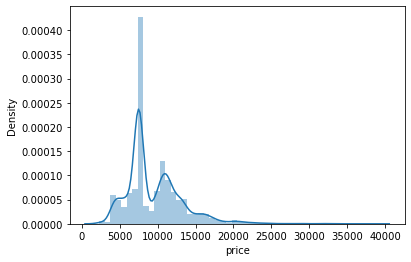

In [35]:
sns.distplot(df["price"])

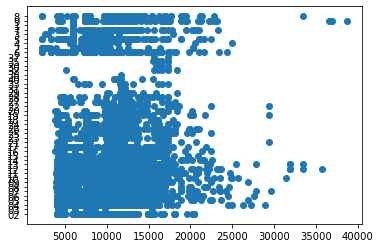

In [36]:
plt.scatter(df['price'],df['Dur_hour'])

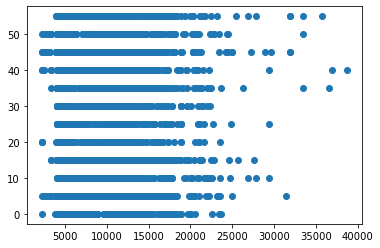

In [37]:
plt.scatter(df['price'],df['Dur_min'])

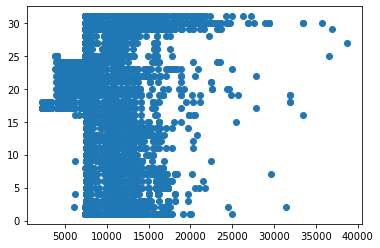

In [38]:
plt.scatter(df['price'],df['Day'])

Observation: We clearly see that price of the flight lies below 5000 Rupee's between 20 to 25 date 

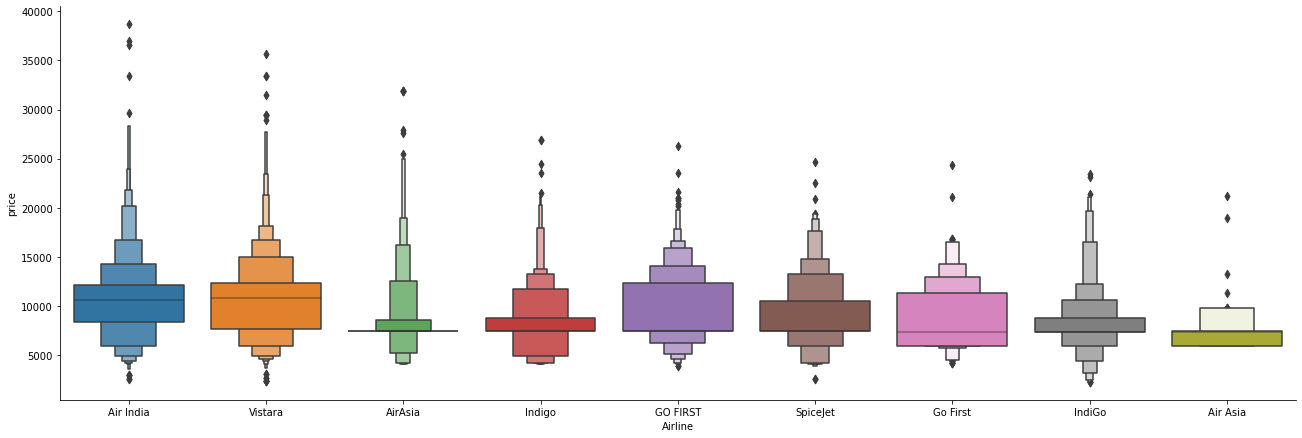

In [39]:

# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "price", x = "Airline", data = df.sort_values("price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

### Feature Selection
    Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

    **heatmap**

    **feature_importance_**
    
   


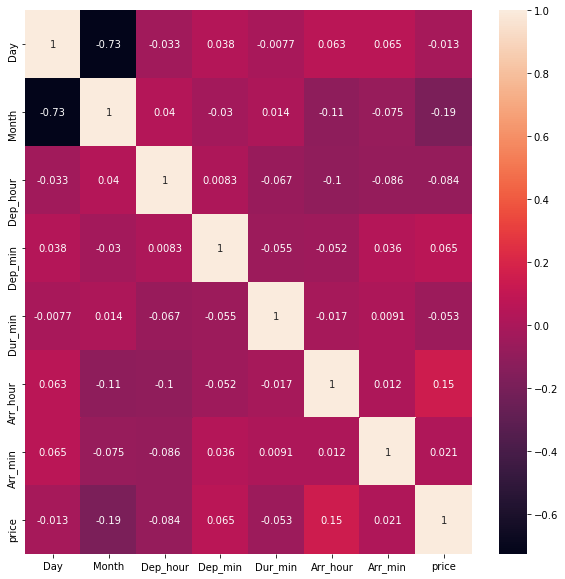

In [40]:
#To check the corr_mat  Heatmap
corr_hmap=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_hmap, annot=True)
plt.show()

In [41]:
#to display the
corr_matrix=df.corr()

#please find the top 10 positive relation with dependet variable SALES PRICE 
corr_matrix['price'].sort_values(ascending = False)

price       1.000000
Arr_hour    0.148662
Dep_min     0.064682
Arr_min     0.020918
Day        -0.012557
Dur_min    -0.052974
Dep_hour   -0.083973
Month      -0.185633
Name: price, dtype: float64

### Handeling the categorical values 

In [42]:
Airline = pd.get_dummies(df['Airline'])
Airline.head()

,Air Asia,Air India,AirAsia,GO FIRST,Go First,IndiGo,Indigo,SpiceJet,Vistara
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0


In [43]:
Source = pd.get_dummies(df["Source"])
Source.head()

,Bangalore,Chennai,New Delhi,bangalore
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [44]:
Destination = pd.get_dummies(df["Destination"])
Destination.head()

,Delhi,Mumbai
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [45]:
# Replacing Stops
df.replace({"non-stop": 0, "1-stop": 1, "2-stop": 2,"3-stop":3}, inplace = True)
df['stop']=pd.to_numeric(df['stop'])

In [46]:
# Concatenate dataframe --> df + Airline + Source + Destination
df = pd.concat([df, Airline, Source, Destination], axis = 1)

df.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [47]:
df.head()

,Day,Month,Route,Dep_hour,Dep_min,Dur_hour,Dur_min,Arr_hour,Arr_min,stop,...,IndiGo,Indigo,SpiceJet,Vistara,Bangalore,Chennai,New Delhi,bangalore,Delhi,Mumbai
0,25,10,BLR--->DEL,6,0,02,40,8,40,0,...,0,0,0,0,1,0,0,0,1,0
1,25,10,BLR--->DEL,21,15,02,40,23,55,0,...,0,0,0,0,1,0,0,0,1,0
2,25,10,BLR--->DEL,2,10,02,40,4,50,0,...,0,0,1,0,1,0,0,0,1,0
3,25,10,BLR--->DEL,12,55,02,45,15,40,0,...,0,1,0,0,1,0,0,0,1,0
4,25,10,BLR--->DEL,14,35,02,45,17,20,0,...,0,1,0,0,1,0,0,0,1,0


### Data Pre-processing

In [48]:
df.columns

Index(['Day', 'Month', 'Route', 'Dep_hour', 'Dep_min', 'Dur_hour', 'Dur_min',
       'Arr_hour', 'Arr_min', 'stop', 'price', 'Air Asia', 'Air India',
       'AirAsia', 'GO FIRST', 'Go First', 'IndiGo', 'Indigo', 'SpiceJet',
       'Vistara', 'Bangalore', 'Chennai', 'New Delhi', 'bangalore', 'Delhi',
       'Mumbai'],
      dtype='object')

In [49]:
#Spliting the data set X and y

X = df.loc[:, ['Air Asia', 'Air India',
       'AirAsia', 'GO FIRST', 'Go First', 'IndiGo', 'Indigo', 'SpiceJet',
       'Vistara','Bangalore', 'Chennai', 'New Delhi', 'bangalore', 'Delhi',
       'Mumbai', 'Day', 'Month', 'Dep_hour', 'Dep_min', 'Dur_hour', 'Dur_min',
       'Arr_hour', 'Arr_min', 'stop'
                                    ]]
y = df['price']

In [50]:
print(X.head(),y.head())

   Air Asia  Air India  AirAsia  GO FIRST  Go First  IndiGo  Indigo  SpiceJet  \
0         0          0        0         1         0       0       0         0   
1         0          0        0         1         0       0       0         0   
2         0          0        0         0         0       0       0         1   
3         0          0        0         0         0       0       1         0   
4         0          0        0         0         0       0       1         0   

   Vistara  Bangalore  ...  Mumbai  Day  Month  Dep_hour  Dep_min  Dur_hour  \
0        0          1  ...       0   25     10         6        0        02   
1        0          1  ...       0   25     10        21       15        02   
2        0          1  ...       0   25     10         2       10        02   
3        0          1  ...       0   25     10        12       55        02   
4        0          1  ...       0   25     10        14       35        02   

   Dur_min  Arr_hour  Arr_min stop  
0

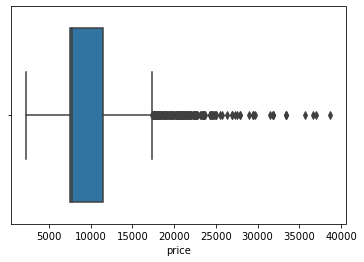

In [51]:
#box plot 
sns.boxplot(df['price'])
plt.show()

In [52]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [53]:
print(selection.feature_importances_)

[0.0010507  0.04317561 0.01218971 0.01165082 0.00298683 0.00463743
 0.00814148 0.00511719 0.05081403 0.01325083 0.01163243 0.00168272
 0.00037532 0.00192923 0.00194131 0.36300374 0.05482524 0.05955162
 0.05146523 0.06017821 0.03963051 0.06255457 0.05846406 0.07975117]


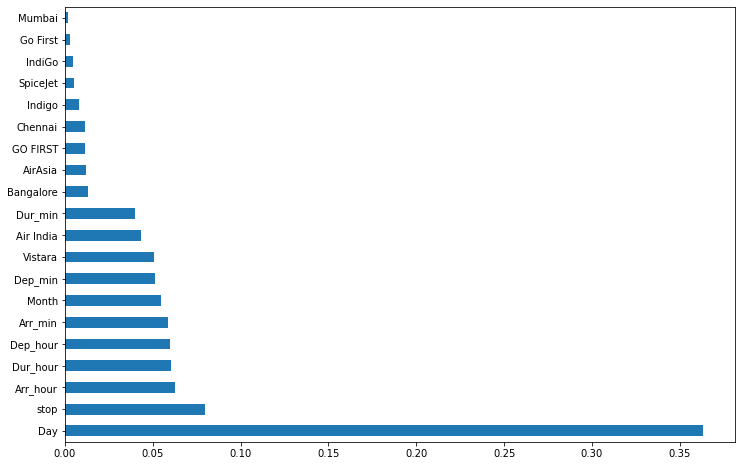

In [54]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

##### spliting the data into train set and test set

In [55]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Model Building

##### Random forest model

In [56]:
#Random forest model

from sklearn.ensemble import RandomForestRegressor
Forest = RandomForestRegressor()
Forest.fit(X_train, y_train)
y_pred = Forest.predict(X_test)
                        

In [57]:
#model traing score
Forest.score(X_train, y_train)

0.9554570748989741

In [58]:
#test score
Forest.score(X_test, y_test)

0.7204546061808934

In [59]:
Forest.score(X_test, y_test)

0.7204546061808934

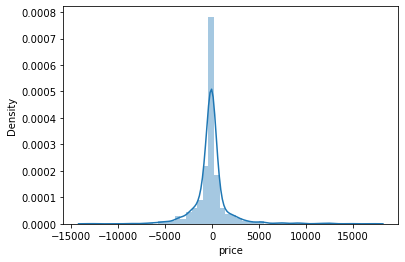

In [60]:
#y_test, and y_predicted plot
sns.distplot(y_test-y_pred)
plt.show()

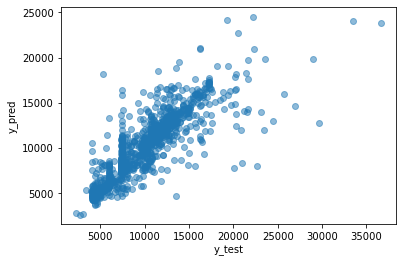

In [61]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [62]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2_score:',metrics.r2_score(y_test, y_pred))

MAE: 992.0886664656771
MSE: 3800868.043425692
RMSE: 1949.5815046890684
R2_score: 0.7204546061808934


##### logistic regressionModel

In [63]:
#logistic regressionModel

from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression()
Logistic.fit(X_train,y_train)
l_prediction  =Logistic.predict(X_test)



In [64]:
Logistic.score(X_train,y_train)

0.3354440655950641

In [65]:
Logistic.score(X_test,y_test)

0.31493506493506496

In [66]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, l_prediction))
print('MSE:', metrics.mean_squared_error(y_test, l_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, l_prediction)))
print('R2_score:',metrics.r2_score(y_test, l_prediction))

MAE: 2283.7512987012988
MSE: 14446663.651298702
RMSE: 3800.8766950926865
R2_score: -0.0625199911267118


#### Decision Tree regression model

In [67]:
#decision Tree model 
from sklearn.tree import DecisionTreeRegressor
DTR=DecisionTreeRegressor()
DTR.fit(X_train,y_train)
DTR_pred=DTR.predict(X_test)


In [68]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, DTR_pred))
print('MSE:', metrics.mean_squared_error(y_test, DTR_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, DTR_pred)))
print('R2_score:',metrics.r2_score(y_test, DTR_pred))


MAE: 1097.2801948051947
MSE: 6134578.683603896
RMSE: 2476.808164473764
R2_score: 0.5488153773218791


### Linear Regression model

In [69]:
from sklearn.linear_model import LinearRegression
Regressor=LinearRegression()
Regressor.fit(X_train,y_train)
pred =Regressor.predict(X_test)


In [70]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('R2_score:',metrics.r2_score(y_test, pred))

MAE: 2244.6910277664074
MSE: 9795682.81881801
RMSE: 3129.805556071816
R2_score: 0.27954930820342405


#### Hyperparameter Tuning
    Choose following method for hyperparameter tuning
    RandomizedSearchCV --> Fast
    GridSearchCV
    Assign hyperparameters in form of dictionery
    Fit the model
    Check best paramters and best score

In [71]:
from sklearn.model_selection import RandomizedSearchCV

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [72]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [73]:

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = Forest, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [74]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test=train_test_split(X,y, train_size=0.8, test_size=0.2,random_state=42 )

In [76]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [78]:

prediction = rf_random.predict(X_test)

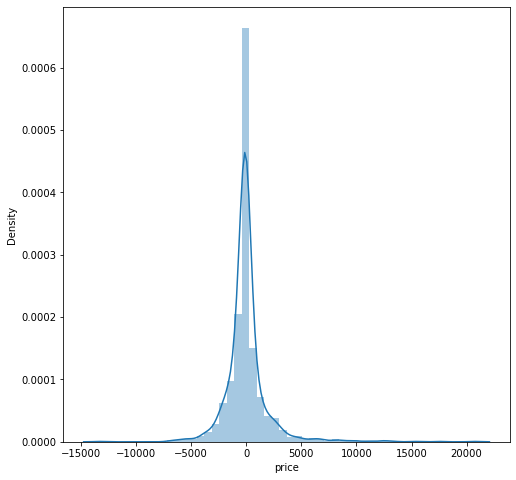

In [79]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

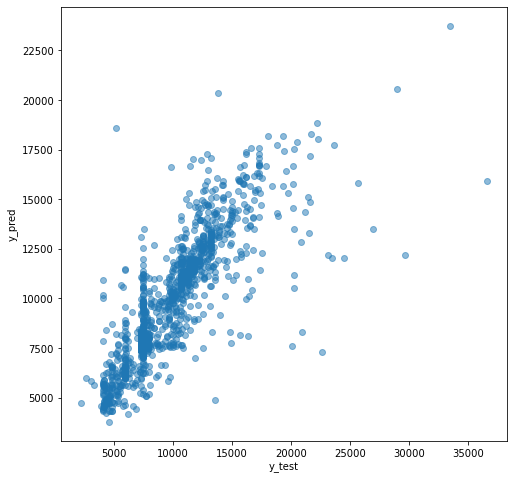

In [80]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [81]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1043.1937684506358
MSE: 4068648.463067718
RMSE: 2017.0891063777322


In [82]:
y_prediction = rf_random.predict(X_test)
metrics.r2_score(y_test, y_prediction)

0.7007599516939125

### Saving the model

In [83]:
import pickle
# open a file, where you ant to store the data
file = open('Forest.pkl', 'wb')

# dump information to that file
pickle.dump(Forest, file)

In [84]:

model = open('Forest.pkl','rb')
forest = pickle.load(model)